Now We are going to Use Entire Fashion Mnist Data set.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Set a manual seed so that anyone running this notebook will have same result
torch.manual_seed(42)

## **Steps to Perform on GPU**

1. Check the availability of GPU
2. Move the Model to GPU
3. Modify the Training Loop by Moving Data to GPU
4. Modify the Evaluation Loop by Moving Data to GPU
5. Optimize the GPU Usage:

- Creating Bigger Batches like 64, 128 etc.

- User `pin_memory=True` to make data loading from cpu to gpu faster.

generally data is in pager memory and go to pin memory and then comes for loading.
So here we are directly keeping it on pinned memory so the time from getting page to pin and then to us is reduced.
These are just the concept of Operating System



In [6]:
"""
Always check the availability of the GPU
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )

print(f"Using the {device}")


Using the cuda


In [7]:
# Read data

df = pd.read_csv("/content/fashion-mnist_train.csv")

df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df.shape

(60000, 785)

So we have 784 features.

One Label

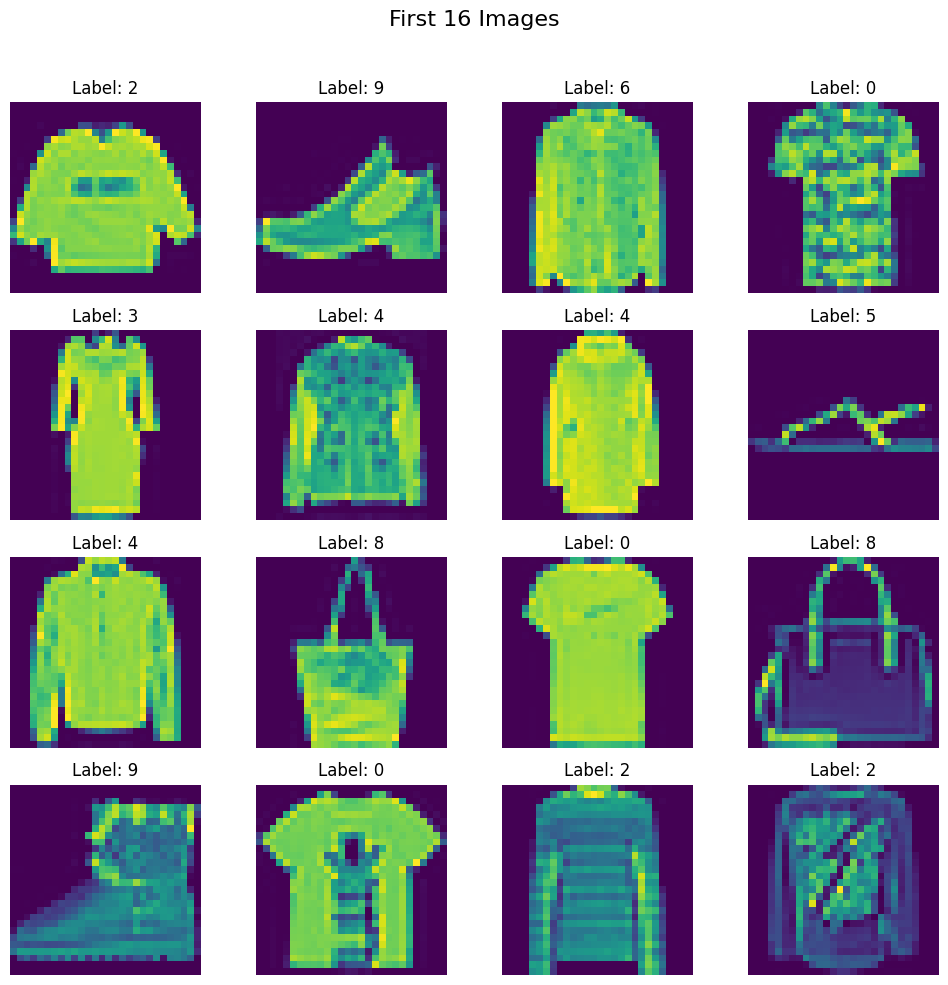

In [9]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [10]:
df['label'].nunique()

10

In [11]:
df['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1])

So this is a Multiclass Classification Problem we have 10 different Classess.

In [12]:
# x = df.iloc[:,1:]
x = df.iloc[:,1:].values

In [13]:
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [14]:
x.shape

(60000, 784)

In [15]:
# Only label col
y = df.iloc[:,0].values

In [16]:
y

array([2, 9, 6, ..., 8, 8, 7])

In [17]:
y.shape

(60000,)

In [18]:
# Perform the splitting on Data
x_train, x_test , y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [19]:
x_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [20]:
x_test

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ..., 211, 102,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [21]:
y_train

array([5, 7, 8, ..., 9, 4, 0])

In [22]:
y_test

array([7, 8, 8, ..., 9, 5, 5])

Now we can see that Most of the values in our data is 0 but some places have higher values because they are representating pixel values so we need to Normalize/Scale this between 0 to 1. We can simply do this by dividing the data with 255 Because we have 256 pixels in an image

In [23]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [24]:
x_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00392157, 0.        ,
        0.        ]])

## Dataset Class

In [25]:
class CustomDataset(Dataset):

  def __init__(self, features, labels):
    """
    This thing we need to remember that Pytorch wants features as Float
    and labels as Long.
    So we are converting this here only.
    """
    self.features = torch.tensor(features, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
     return self.features[index], self.labels[index]

In [26]:
# train dataset object

train_dataset = CustomDataset(x_train, y_train)

In [27]:
train_dataset

In [28]:
len(train_dataset)

48000

In [29]:
train_dataset[0]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2275,
         0.5333, 0.0000, 0.0

In [30]:
# Test Dataset

test_dataset = CustomDataset(x_test, y_test)

In [31]:
test_dataset

In [32]:
len(test_dataset)

12000

**DATA LOADER for Batches**

In [33]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Because while prediction we dont need shuffling
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [34]:
# total batches
len(train_loader)

1500

## **NEURAL Network**

Keep This in Mind For Achitecture

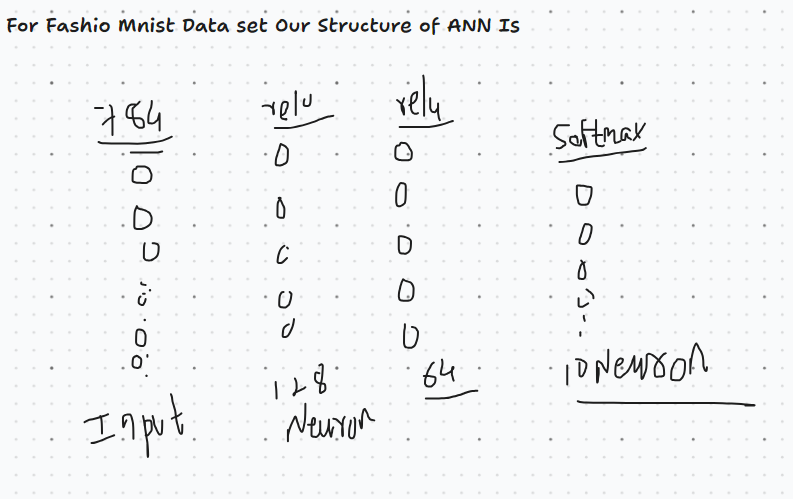

In [35]:
class MyNetwork(nn.Module):

  # constructor
  def __init__(self, num_features):
    super().__init__()
    # Create Architecture
    self.model = nn.Sequential(
        nn.Linear(num_features,128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,10),
        # nn.Softmax() We dont have to add this because by default in cross entorpy loss Softmax is internally Implemented
    )

  # forward
  def forward(self,x):
    # Just pass the number of featurs recievd to model
    return self.model(x)

## **Training PipeLine**

**Define Params**

In [36]:
# Parameters

epochs = 100
learning_rate = 0.2

In [37]:
# Model
# Here we are only passing the number of features not actual data
model = MyNetwork(x_train.shape[1])

In [38]:
"""
Move the Model to GPU
"""

model.to(device)

MyNetwork(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [39]:
# Loss function
criteria = nn.CrossEntropyLoss()

In [40]:
# Optimizer
# Pass weights and Bias and learning Rate
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

**Actual training**

In [41]:
for epoch in range(epochs):

  # just to check all batches loss
  total_epoch_loss = 0
  for batch_features, batch_labels in train_loader:

    """
    Move data to gpu
    """
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)


    # forward pass
    outputs = model.forward(batch_features)

    # calculate loss
    loss = criteria(outputs, batch_labels)

    # clear gradient
    optimizer.zero_grad()

    # backprop(calculate gradient)
    loss.backward()

    # update weigths and bias
    optimizer.step()

    # Add to epoch loss just for checking loss of each epoch
    total_epoch_loss += loss

  # Average Loss
  avg_loss = total_epoch_loss/len(train_loader)

  print(f"Epoch:{epoch +1}, Loss:{avg_loss}")
  print("-"*30)


Epoch:1, Loss:0.6035256385803223
------------------------------
Epoch:2, Loss:0.4261108338832855
------------------------------
Epoch:3, Loss:0.38409098982810974
------------------------------
Epoch:4, Loss:0.35766544938087463
------------------------------
Epoch:5, Loss:0.33800140023231506
------------------------------
Epoch:6, Loss:0.3237955570220947
------------------------------
Epoch:7, Loss:0.3096260130405426
------------------------------
Epoch:8, Loss:0.2979039251804352
------------------------------
Epoch:9, Loss:0.2883312404155731
------------------------------
Epoch:10, Loss:0.2776045799255371
------------------------------
Epoch:11, Loss:0.2721799612045288
------------------------------
Epoch:12, Loss:0.26296910643577576
------------------------------
Epoch:13, Loss:0.25780898332595825
------------------------------
Epoch:14, Loss:0.24863217771053314
------------------------------
Epoch:15, Loss:0.24390488862991333
------------------------------
Epoch:16, Loss:0.2349339127

## **Evaluation**

First we need to set the Model to Evaluation mode.

Why we need to do so?? Why explicitly call the model to turn on evaluation mode.

Becasue in Neural Network Some features Behave different while Training and behave differently while evaluation.

**Examples:**

- Drop Layers (They Behave different while training and when testing all neurons are available).

- Batch Normalization. While training we calculate mean and std by seeing the data.

Thus we need to tell the model That we are using it for evaluation.

In [42]:
# Set to Evaluation Mode

model.eval()

MyNetwork(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [43]:
# Variables for evaluation
total = 0
correct = 0


with torch.no_grad():

  # Since our testing data is also in batches.

  for batch_features, batch_labels in test_loader:

      """
      Move data to gpu
      """
      batch_features = batch_features.to(device)
      batch_labels = batch_labels.to(device)


      # predict on each image
      outputs = model.forward(batch_features)

      # check if it is correct or not
      # See Below Explaination
      # Row wise we need to check for each outputs max value
      # This will return value and index
      idx, v = torch.max(outputs, 1)

      # update total (Add rows)
      total += batch_labels.shape[0]

      # Correct (where predicted is same as batch_label)

      correct = correct + (v == batch_labels).sum()

accuracy = (correct/total)

print(f"Accuracy:{accuracy}")

Accuracy:0.8814166784286499


In [44]:
len(test_loader)

375

**How we calculate the Outputs**

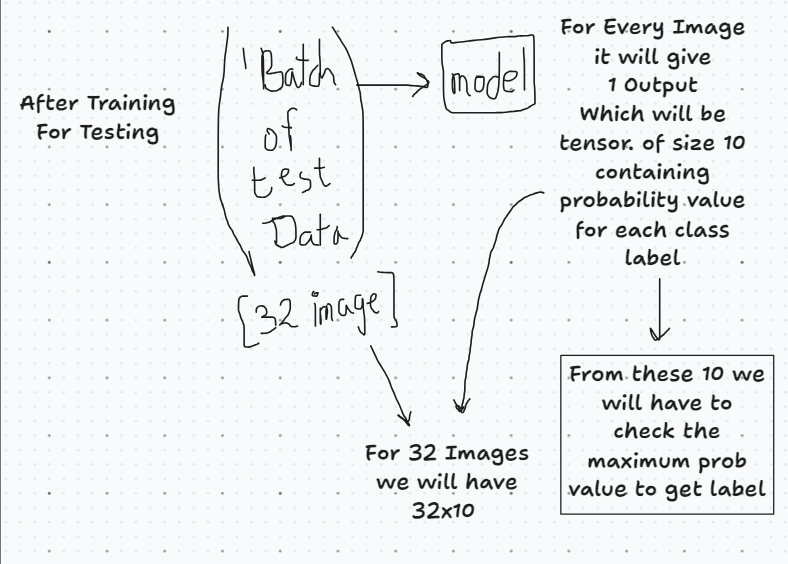

- 1 Batch of test data means 32 images.

- We will get 1 output for each images containing a tensor of size 10. Because we have 10 class, so the tensor will contain 10 probability values.

- For 1 batch i.e 32 images we will have 32 tensors of size 10 i.e 32x10.

- From Each tensor we will compare probability and get the label of max probability value.

- Example:
[0,1,0,0,0,]
so the max is 1 at 2nd label i.e the Label is 2. This is just example

## **Can We Increase the Accuracy**

Answer is Yes..

How???

- Use full dataset (but for this needed GPU)

- Different Optimizers

- Hyperparameter Tuning with epochs, learning rates.

- weight initialization technique

- Drop out concept

- Regularization

- Model Architecture etc.etc.

We can do all things which we have Learned in Deep Learning.